In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os
sys.path.insert(0, os.path.abspath('..'))

from toy_model import state_event_model
from toy_model.state_event_generator import *
from toy_model.utils import plot_event_paper_style

import numpy as np

ModuleNotFoundError: No module named 'toy_model'

In [ ]:
dz = 33
n_particles = [3, 3] 
events = len(n_particles)
layers = 5
n = np.sum(n_particles)

module_id = [l for l in range(1, layers+1)]
lx = [33 for x in range(1, layers+1)]
ly = [33 for x in range(1, layers+1)]
zs = [dz*l for l in range(1, layers+1)]

Detector = state_event_model.PlaneGeometry(module_id=module_id, lx=lx, ly=ly, z=zs)

state_event_gen = StateEventGenerator(Detector, events=len(n_particles), n_particles=n_particles,
                                    measurement_error=0.0, collision_noise=0.00)

state_event_gen.set_primary_vertices(
    [
        (0, 0, 100),   
        (0, 0, -50)     
    ]
)

event_particles = []
for event in range(events):
    particles_list = []
    for particle in range(n_particles[event]):
        particle_dict = {'type': 'MIP', 'mass': 0.511, 'q': 1}
        particles_list.append(particle_dict)
    event_particles.append(particles_list)

state_event_gen.generate_particles(event_particles)
event_tracks = state_event_gen.generate_complete_events()

In [ ]:
def plot_event_paper_style(event_tracks, detector, figsize=(10, 6), dpi=300,
                           filename="paper_event_display", save_to_file=True,
                           label_si_pos=None, label_sj_pos=None, show_pv=True):
    """
    Create a publication-quality event display matching the paper figure style.
    
    Parameters:
    -----------
    event_tracks : Event object or list of Event objects
        The generated event(s) containing tracks and hits
    detector : PlaneGeometry
        The detector geometry
    figsize : tuple
        Figure size in inches (default: (10, 6))
    dpi : int
        Figure resolution (default: 300)
    filename : str
        Output filename (default: "paper_event_display")
    save_to_file : bool
        Whether to save the figure (default: True)
    label_si_pos : tuple (x, y) or None
        Position for S_i = 1 label (default: None, uses automatic positioning)
    label_sj_pos : tuple (x, y) or None
        Position for S_j = 0 label (default: None, uses automatic positioning)
    show_pv : bool
        Whether to show primary vertices (default: True)
    """
    # Set publication style
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['font.serif'] = ['Times New Roman', 'DejaVu Serif']
    plt.rcParams['font.size'] = 11
    plt.rcParams['axes.linewidth'] = 1.2
    plt.rcParams['xtick.major.width'] = 1.2
    plt.rcParams['ytick.major.width'] = 1.2
    
    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    
    if isinstance(event_tracks, list):
        event = event_tracks[0] 
    else:
        event = event_tracks

    layer_positions = sorted(set(detector.z))
    
    hits_by_layer = {z: [] for z in layer_positions}
    for hit in event.hits:
        z_pos = hit[2]  # z-coordinate
        hits_by_layer[z_pos].append(hit)
    
    all_y_values = [hit[1] for hit in event.hits]
    y_min, y_max = min(all_y_values), max(all_y_values)
    y_range = y_max - y_min
    y_margin = 0.15 * y_range
    
    for z_pos in layer_positions:
        ax.axvline(x=z_pos, color='black', linewidth=4, zorder=1, alpha=0.8)
    
    track_colors = [
    '#E74C3C',  # Red
    '#3498DB',  # Blue
    '#2ECC71',  # Green
    '#F39C12',  # Orange
    '#9B59B6',  # Purple
    '#1ABC9C',  # Turquoise
    '#E67E22',  # Dark orange
    '#D35400',  # Burnt orange
    '#16A085',  # Dark turquoise
    '#C0392B',  # Dark red
    ]

    track_ids = sorted(set(hit.track_id for hit in event.hits))

    track_y_avg = {}
    for tid in track_ids:
        track_hits = [hit for hit in event.hits if hit.track_id == tid]
        track_y_avg[tid] = np.mean([hit[1] for hit in track_hits])

    sorted_tracks = sorted(track_ids, key=lambda tid: track_y_avg[tid], reverse=True)

    color_palette = [
        '#F39C12',  # Yellow/Orange - TOP
        '#E67E22',  # Orange
        '#E74C3C',  # Red
        '#9B59B6',  # Purple - MIDDLE
        '#2ECC71',  # Green
        '#1ABC9C',  # Turquoise
        '#3498DB',  # Blue - BOTTOM
        '#16A085',  # Dark turquoise
    ]

    track_id_to_color = {tid: color_palette[i % len(color_palette)] 
                        for i, tid in enumerate(sorted_tracks)}
    
    for i in range(len(layer_positions) - 1):
        z1 = layer_positions[i]
        z2 = layer_positions[i + 1]
        
        for hit1 in hits_by_layer[z1]:
            for hit2 in hits_by_layer[z2]:
                if hit1.track_id != hit2.track_id:
                    ax.plot([hit1[2], hit2[2]], [hit1[1], hit2[1]], 
                           color='black', linewidth=1.0, alpha=0.5, zorder=1)
    
    for i in range(len(layer_positions) - 1):
        z1 = layer_positions[i]
        z2 = layer_positions[i + 1]
        
        for hit1 in hits_by_layer[z1]:
            for hit2 in hits_by_layer[z2]:
                if hit1.track_id == hit2.track_id:
                    color = track_id_to_color.get(hit1.track_id, '#95A5A6')
                    ax.plot([hit1[2], hit2[2]], [hit1[1], hit2[1]], 
                           color=color, linewidth=3.0, alpha=0.95, zorder=3)
    
    if show_pv and hasattr(event, 'primary_vertices') and event.primary_vertices:
        for pv in event.primary_vertices:
            pv_x = pv[0] if len(pv) > 0 else 0
            pv_y = pv[1] if len(pv) > 1 else 0
            pv_z = pv[2] if len(pv) > 2 else 0
            
            ax.scatter(pv_z, pv_y, s=200, c='black', marker='*', 
                      zorder=10, edgecolors='black', linewidths=1.5)
            
            first_layer_z = min(layer_positions)
            for hit in hits_by_layer[first_layer_z]:
                color = track_id_to_color.get(hit.track_id, '#95A5A6')
                ax.plot([pv_z, hit[2]], [pv_y, hit[1]], 
                       color=color, linewidth=4.0, alpha=0.95, 
                       linestyle='--', zorder=2)
    
    for hit in event.hits:
        ax.scatter(hit[2], hit[1], s=90, c='black', zorder=4, edgecolors='none')
        ax.scatter(hit[2], hit[1], s=35, c='white', zorder=5, edgecolors='none')
    
    ax.set_xlim(min(layer_positions) - 5, max(layer_positions) + 5)
    ax.set_ylim(y_min - y_margin, y_max + y_margin)
    
    if label_si_pos is not None:
        ax.text(label_si_pos[0], label_si_pos[1], '$S_i = 1$',
               fontsize=18, fontweight='bold', ha='center', va='center', rotation=-18)
    
    if label_sj_pos is not None:
        ax.text(label_sj_pos[0], label_sj_pos[1], '$S_j = 0$',
               fontsize=18, fontweight='bold', ha='center', va='center',)
    
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    
    ax.set_facecolor('none')
    fig.patch.set_alpha(0.0)
    plt.tight_layout()
    
    if save_to_file:
        figures_dir = os.path.join('Plots')
        os.makedirs(figures_dir, exist_ok=True)
        save_path = os.path.join(figures_dir, filename)
        plt.savefig(save_path + '.pdf', bbox_inches='tight', 
                   transparent=False, facecolor='white', dpi=dpi)
        plt.savefig(save_path + '.jpeg', bbox_inches='tight', 
                   transparent=False, facecolor='white', dpi=dpi)
        print(f"Figure saved to {save_path}")
    
    plt.show()
    
    plt.rcParams.update(plt.rcParamsDefault)

Figure saved to Plots/paper_event_display


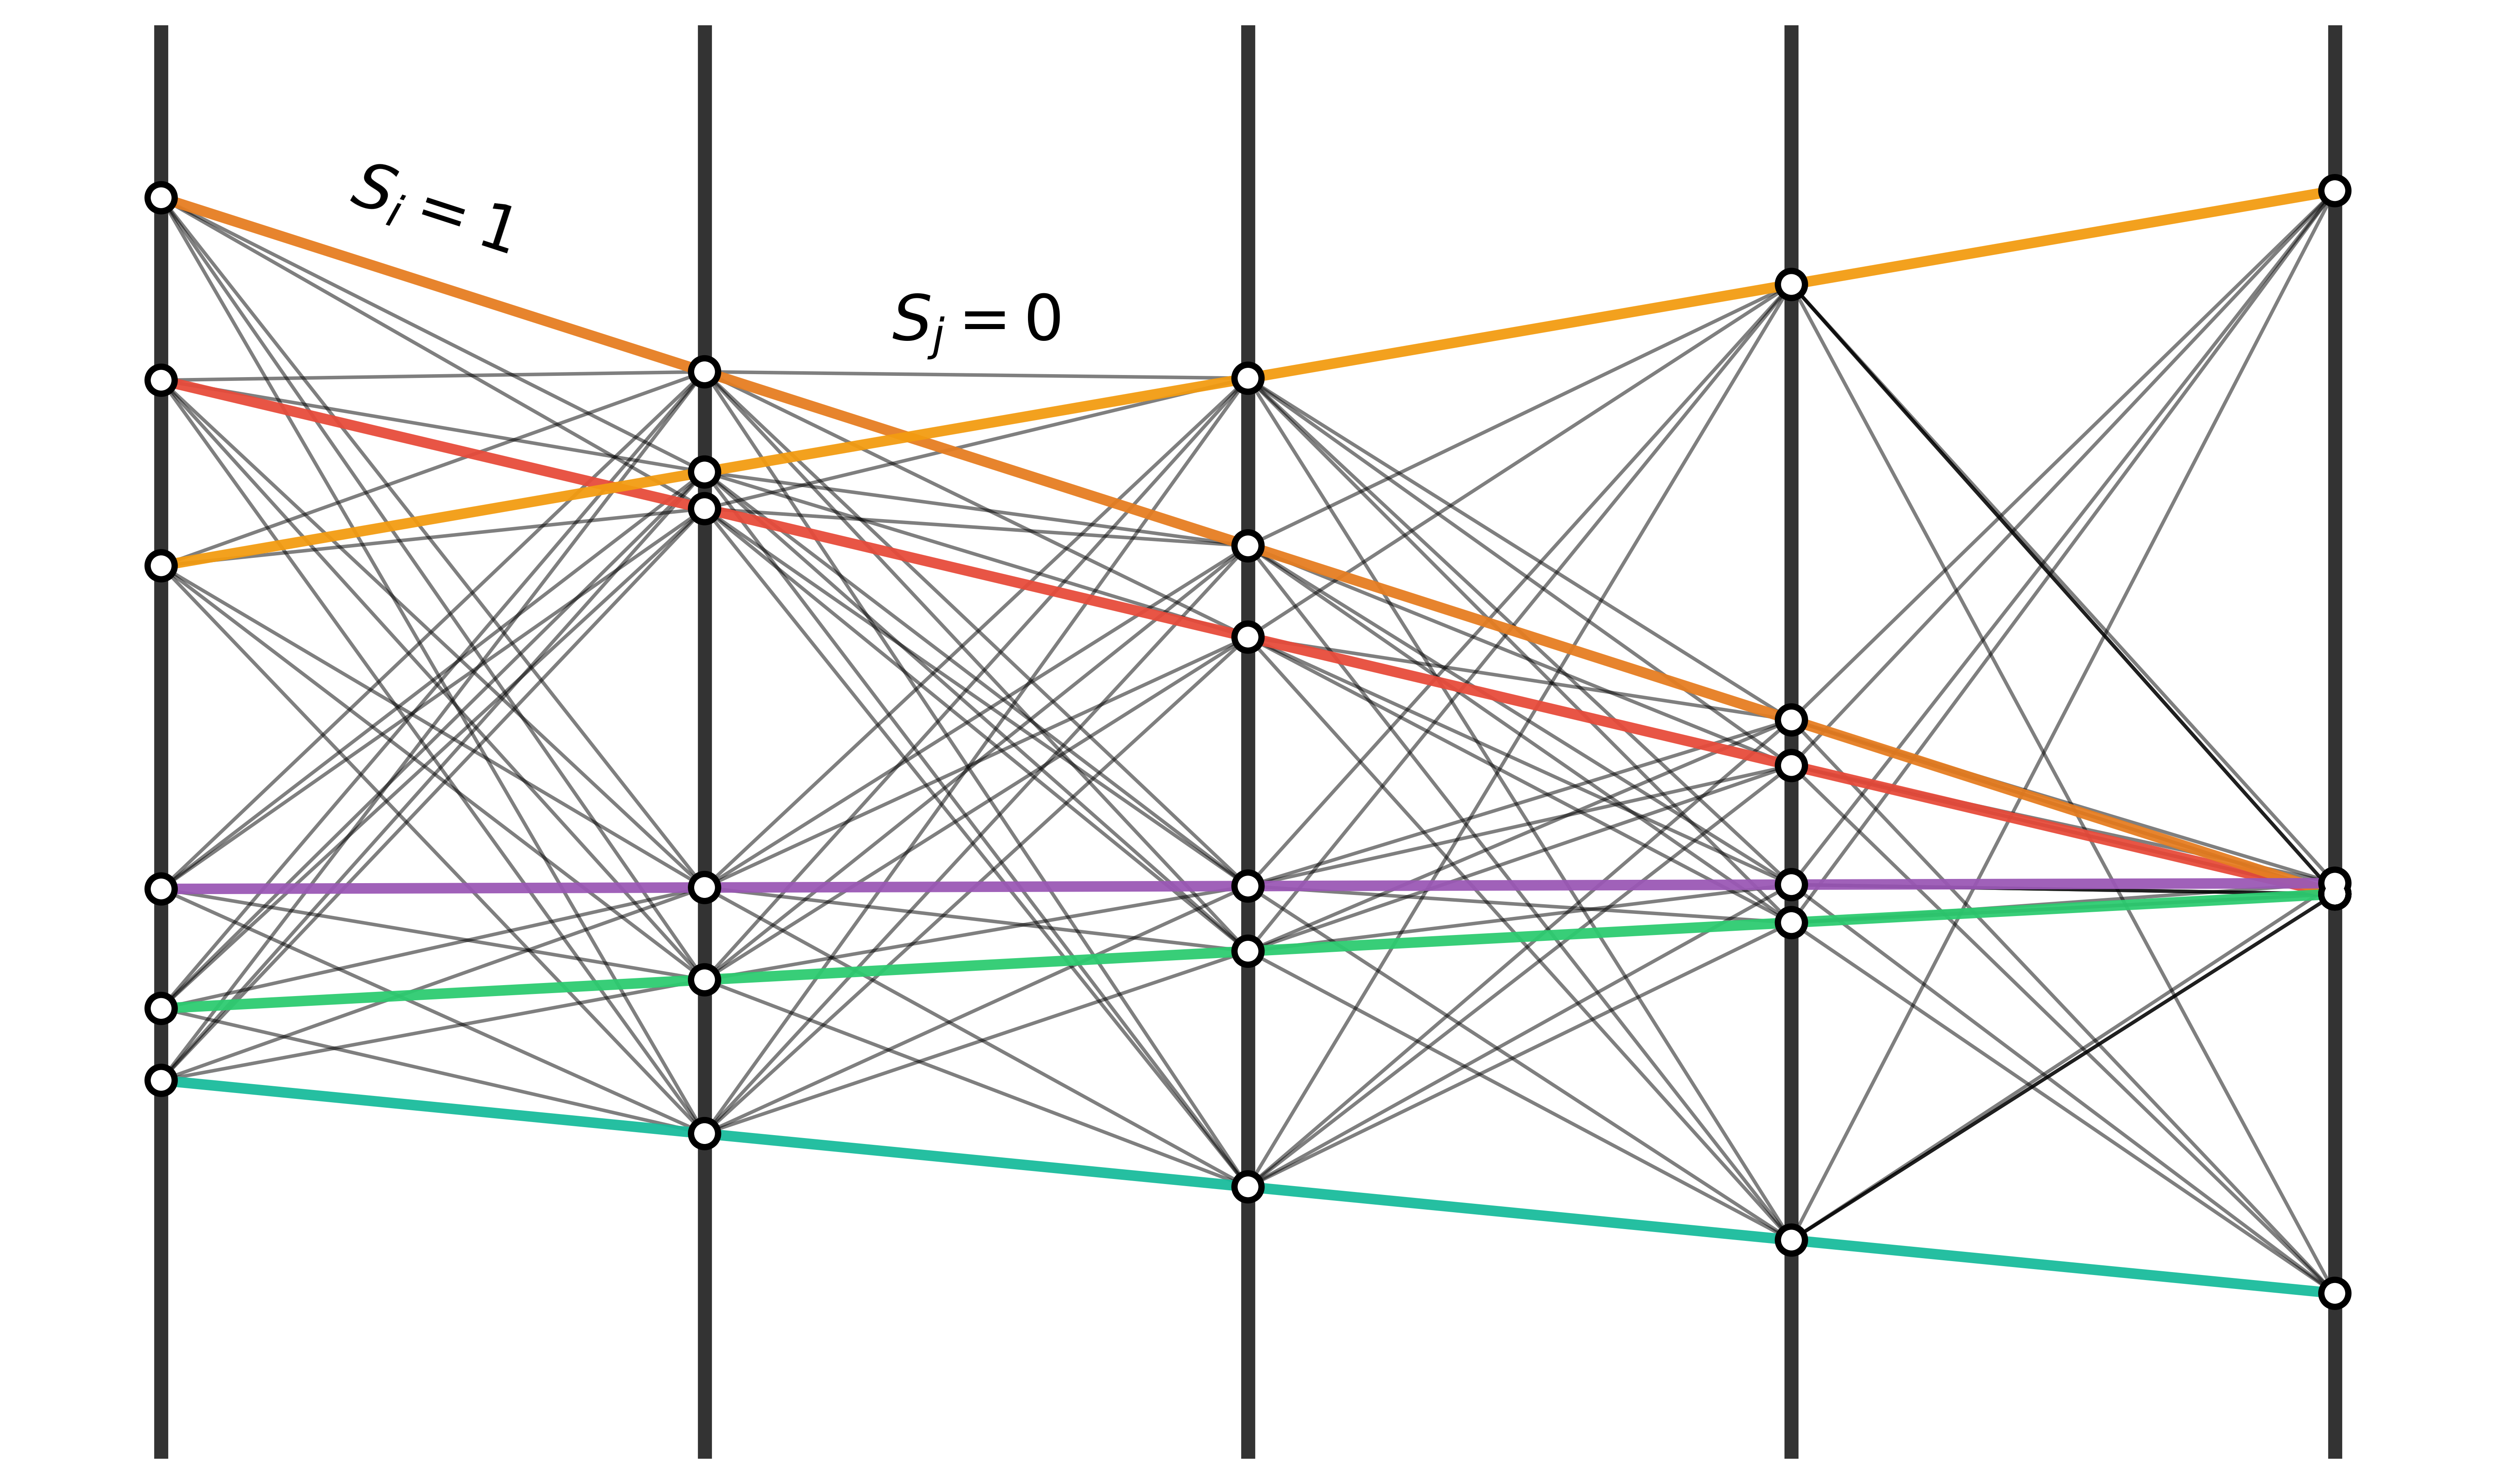

In [ ]:
plot_event_paper_style(event_tracks, Detector, 
                      figsize=(10, 6), 
                      dpi=600,
                      filename='paper_event_display',
                      save_to_file=True,
                      label_si_pos=(30, 12),   
                      label_sj_pos=(50, 10),  
                      show_pv=False)        